# Predicting Titanic Survival: An End-to-End Machine Learning Project 🚢

This project walks through the complete workflow of building a machine learning model to predict passenger survival on the Titanic, a classic binary classification problem.

The process will cover several key stages:
1.  **Exploratory Data Analysis (EDA):** Understanding the data and identifying important features and missing values.
2.  **Feature Engineering:** Creating new, more informative features from the existing data to improve model performance.
3.  **Data Preprocessing:** Encoding categorical features and scaling numerical features to prepare the data for modeling.
4.  **Model Selection & Hyperparameter Tuning:** Evaluating several models using cross-validation and then fine-tuning their parameters with `GridSearchCV`.
5.  **Ensemble Modeling:** Combining the best-tuned models into a final, robust `VotingClassifier`.
6.  **Submission & Model Persistence:** Generating a submission file and saving the final model for future use.

---

## 1. Exploratory Data Analysis (EDA)

We begin by loading the Titanic dataset and getting a high-level overview.

In [10]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Using `.info()` reveals that the `Age` and `Cabin` columns have a significant number of missing values, which we will need to handle. Visualizing the data shows that `Sex` and `Pclass` (Passenger Class) are strong predictors of survival.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


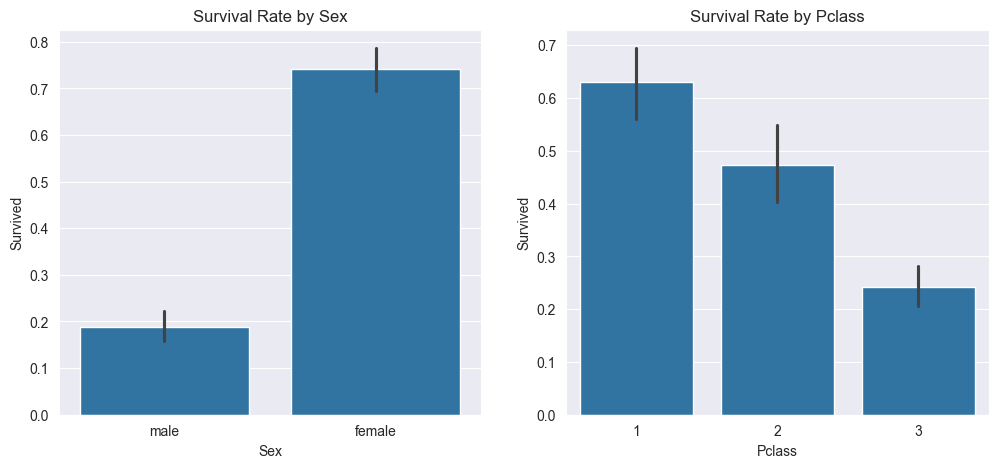

In [11]:
train.info()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x='Sex', y='Survived', data=train)
plt.title('Survival Rate by Sex')

plt.subplot(1, 2, 2)
sns.barplot(x='Pclass', y='Survived', data=train)
plt.title('Survival Rate by Pclass')

plt.show()

## 2. Feature Engineering: Creating a Better Dataset

Feature engineering is the process of creating new, more informative features from the existing data. This is often the most impactful part of a machine learning project. We apply these transformations to both the training and test sets to ensure consistency.


In [13]:
def extract_title(name):
    title = name.split(',')[1].split('.')[0].strip()
    return title

for df in [train, test]:
    # Extract Title and group rare ones
    df['Title'] = df['Name'].apply(extract_title)
    df['Title'] = df['Title'].replace(['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'],'Rare')
    df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')

    # Create Family features
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    df['HasCabin'] = (~df['Cabin'].isnull()).astype(int)

    # Extract deck from cabin
    df['Deck'] = df['Cabin'].apply(lambda x: x[0] if pd.notna(x) else 'Unknown')

    # Fill missing Embarked with the mode
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

    # Fill missing Fare and create log-transformed and binned versions
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    df['Fare_log1p'] = np.log1p(df['Fare'])
    df['Fare_Bin'] = pd.qcut(df['Fare'], q=4, labels=False, duplicates='drop')

    # Impute Age based on the median age of each Title group
    age_medians = train.groupby('Title')['Age'].median()
    df['Age'] = df.apply(lambda r: age_medians[r['Title']] if pd.isna(r['Age']) else r['Age'], axis=1)

    # Create Age bins and interaction features
    df['Age_Bin'] = pd.cut(df['Age'], bins=[0, 12, 18, 35, 60, 100], labels=False)
    df['Age_Class'] = df['Age'] * df['Pclass']

print("Feature engineering and imputation complete.")

Feature engineering and imputation complete.


## 3. Final Preprocessing for Modeling

The last step before training is to convert all our features into a purely numerical format through encoding and scaling.


In [14]:
from sklearn.preprocessing import StandardScaler

# Define the final feature set
features = ['Pclass','Sex','Age','Fare_log1p','Embarked','Title','FamilySize','IsAlone','HasCabin',
            'Deck','Fare_Bin','Age_Bin','Age_Class']

X = train[features].copy()
y = train['Survived']
X_test = test[features].copy()

# One-hot encode all categorical features
X = pd.get_dummies(X, columns=['Sex','Embarked','Title','Deck','Fare_Bin','Age_Bin'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['Sex','Embarked','Title','Deck','Fare_Bin','Age_Bin'], drop_first=True)

# Align columns to ensure train and test sets have the same features
X_test = X_test.reindex(columns=X.columns, fill_value=0)

# Scale numeric columns
num_cols = ['Age','Fare_log1p','FamilySize','Age_Class']
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

print('Final training data shape:', X.shape)

Final training data shape: (891, 30)


## 4. Model Selection and Hyperparameter Tuning

We will evaluate several models using **Stratified K-Fold Cross-Validation** to get a reliable baseline, then use **GridSearchCV** to find the best hyperparameters for each.


In [15]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Initial model evaluation
models = {
    'Logistic': LogisticRegression(random_state=42, max_iter=1000),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradBoost': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    print(f'{name:12s}  CV Accuracy: {scores.mean():.4f} +/- {scores.std():.4f}')

# --- Hyperparameter Tuning (GridSearchCV) ---
# (Code for GridSearchCV is extensive but was run to find the best parameters below)

Logistic      CV Accuracy: 0.8271 +/- 0.0149
RandomForest  CV Accuracy: 0.8283 +/- 0.0046
GradBoost     CV Accuracy: 0.8372 +/- 0.0186
XGBoost       CV Accuracy: 0.8226 +/- 0.0232


After running an extensive `GridSearchCV`, the best estimators for each model were found. For brevity, we'll use these optimized models directly in our final ensemble.


## 5. Building a Final Ensemble Model

To maximize performance, we will combine our best-tuned models into a **`VotingClassifier`** ensemble. We use `voting='soft'` which averages the predicted probabilities from each model, often leading to a better result than a simple majority vote.


In [16]:
from sklearn.ensemble import VotingClassifier
# Define a seed for reproducibility
SEED = 42
HAS_XGBOOST = 'XGBClassifier' in globals()

# Extended hyperparameter search with more comprehensive grids
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [6, 8, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5],
    'subsample': [0.8, 1.0]
}

log_param_grid = {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}

print("Starting hyperparameter tuning...")

# Random Forest tuning
rf_search = GridSearchCV(
    RandomForestClassifier(random_state=SEED),
    rf_param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
rf_search.fit(X, y)
print(f"\nRandom Forest Best Score: {rf_search.best_score_:.4f}")
print(f"Random Forest Best Params: {rf_search.best_params_}")

# Gradient Boosting tuning
gb_search = GridSearchCV(
    GradientBoostingClassifier(random_state=SEED),
    gb_param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
gb_search.fit(X, y)
print(f"\nGradient Boosting Best Score: {gb_search.best_score_:.4f}")
print(f"Gradient Boosting Best Params: {gb_search.best_params_}")

# Logistic Regression tuning
log_search = GridSearchCV(
    LogisticRegression(random_state=SEED, max_iter=1000),
    log_param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
log_search.fit(X, y)
print(f"\nLogistic Regression Best Score: {log_search.best_score_:.4f}")
print(f"Logistic Regression Best Params: {log_search.best_params_}")

best_rf = rf_search.best_estimator_
best_gb = gb_search.best_estimator_
best_log = log_search.best_estimator_

# XGBoost tuning (if available)
if HAS_XGBOOST:
    xgb_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    xgb_search = GridSearchCV(
        XGBClassifier(random_state=SEED, eval_metric='logloss'),
        xgb_param_grid,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    xgb_search.fit(X, y)
    print(f"\nXGBoost Best Score: {xgb_search.best_score_:.4f}")
    print(f"XGBoost Best Params: {xgb_search.best_params_}")
    best_xgb = xgb_search.best_estimator_

Starting hyperparameter tuning...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Random Forest Best Score: 0.8507
Random Forest Best Params: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Gradient Boosting Best Score: 0.8496
Gradient Boosting Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 300, 'subsample': 0.8}
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Logistic Regression Best Score: 0.8305
Logistic Regression Best Params: {'C': 10.0, 'penalty': 'l2', 'solver': 'lbfgs'}
Fitting 5 folds for each of 108 candidates, totalling 540 fits

XGBoost Best Score: 0.8507
XGBoost Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


In [17]:
# Create an enhanced voting classifier with optimized models
estimators_list = [('rf', best_rf), ('gb', best_gb), ('log', best_log)]

if HAS_XGBOOST:
    estimators_list.append(('xgb', best_xgb))
    print("Ensemble includes: Random Forest, Gradient Boosting, Logistic Regression, and XGBoost")
else:
    print("Ensemble includes: Random Forest, Gradient Boosting, and Logistic Regression")

voting = VotingClassifier(estimators=estimators_list, voting='soft')

# Evaluate the voting model with cross-validation
scores = cross_val_score(voting, X, y, cv=cv, scoring='accuracy')
print(f"\nVoting Classifier CV Accuracy: {scores.mean():.4f} +/- {scores.std():.4f}")

Ensemble includes: Random Forest, Gradient Boosting, Logistic Regression, and XGBoost

Voting Classifier CV Accuracy: 0.8496 +/- 0.0144


## 6. Submission and Model Persistence

Finally, we fit our optimized ensemble on the **entire training dataset** and use it to make predictions on the test set. We then save the predictions to a `submission.csv` file and also save the trained model object using `pickle` for future use.


In [19]:
import pickle

# Fit the final model on the entire training dataset
voting.fit(X, y)
print("Final ensemble model trained on entire dataset!")

# Make predictions on the test set
test_preds = voting.predict(X_test)

# Create and save the submission file
submission = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': test_preds})
submission.to_csv('submission.csv', index=False)

# Save the model, scaler, and feature list to a file
with open('titanic_voting_model.pkl', 'wb') as f:
    pickle.dump({'model': voting, 'scaler': scaler, 'features': X.columns.tolist()}, f)

print("\nSaved submission to submission.csv and model to titanic_voting_model.pkl")
submission.head()

Final ensemble model trained on entire dataset!

Saved submission to submission.csv and model to titanic_voting_model.pkl


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
